In [ ]:
import mne
from pathlib import Path
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
import random
from mne.time_frequency import tfr_array_morlet

Extracting parameters from /Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/notebooks/../data/processed/P1/binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.


/Users/yinqihuang/.neural_mi_tmp/ipykernel_77044/878389050.py:5: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


data.shape -> (n_epochs, n_channels, n_times): (60, 32, 1792)
n_epochs: 60 n_channels: 32 n_times: 1792
channel names (sample): ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4']
sfreq (Hz): 512.0
time range (s): -0.5 to 2.998046875
Applying 1-30 Hz band-pass...
Filter done.
Temporal channels: ['T7', 'T8'] Tactile channels: ['C3', 'C4']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filter done.
Temporal channels: ['T7', 'T8'] Tactile channels: ['C3', 'C4']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
temporal_epochs shape: (60, 1792)
tactile_epochs shape: (60, 1792)
temporal_epochs shape: (60, 1792)
tactile_epochs shape: (60, 1792)


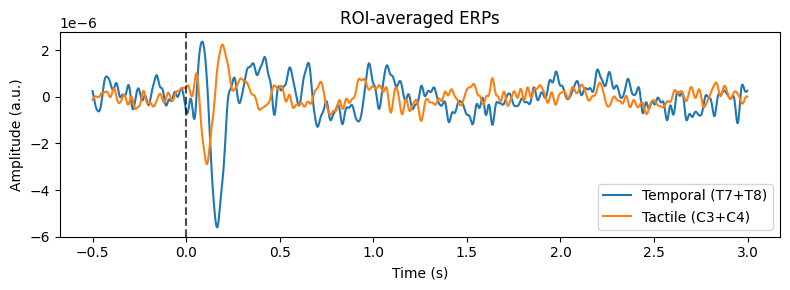

Topomap times: [-0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5]


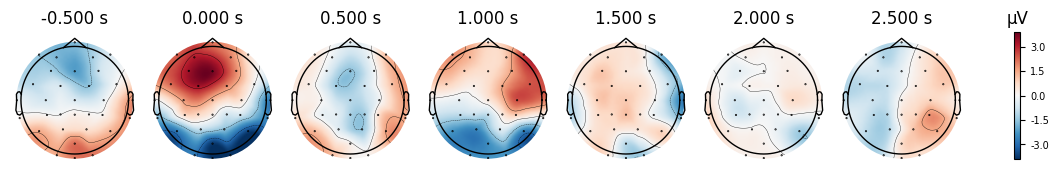

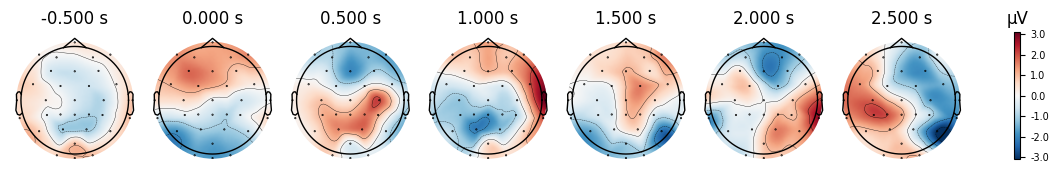

Computing Morlet TFR (complex) — this may take time)...
tfr_complex.shape = (60, 32, 30, 1792)
tfr_complex.shape = (60, 32, 30, 1792)


In [ ]:
# Prepare the data

data_path = Path("../data/processed/P1/")
file_path = data_path / "binepochs filtered ICArej P1AvgBOS2.set"
epochs = mne.io.read_epochs_eeglab(file_path)

auditory_epochs = epochs[::2]

# Work on a copy so we don't accidentally modify the original
aud = auditory_epochs.copy()
aud.load_data()

# Confirm shape and axis mapping
data = aud.get_data()  # (n_epochs, n_channels, n_times)
print('data.shape -> (n_epochs, n_channels, n_times):', data.shape)
n_epochs, n_channels, n_times = data.shape
print('n_epochs:', n_epochs, 'n_channels:', n_channels, 'n_times:', n_times)
print('channel names (sample):', aud.ch_names[:min(16, len(aud.ch_names))])

sfreq = aud.info['sfreq']
print('sfreq (Hz):', sfreq)
print('time range (s):', aud.times[0], 'to', aud.times[-1])

# Apply band-pass 1-30 Hz (in-place on our copy)
print('Applying 1-30 Hz band-pass...')
aud.filter(l_freq=1.0, h_freq=30.0, picks='eeg', fir_design='firwin', verbose=False)
print('Filter done.')

# ROI channels (temporal = T7+T8; tactile = C3+C4)
temporal_chs = [ch for ch in ('T7','T8') if ch in aud.ch_names]
tactile_chs = [ch for ch in ('C3','C4') if ch in aud.ch_names]
print('Temporal channels:', temporal_chs, 'Tactile channels:', tactile_chs)

def roi_mean_epochs(epochs_obj, channels):
    arr = epochs_obj.copy().pick_channels(channels).get_data()  # (n_epochs, n_ch, n_times)
    return arr.mean(axis=1)  # (n_epochs, n_times)

temporal_epochs = roi_mean_epochs(aud, temporal_chs) if len(temporal_chs) else None
tactile_epochs = roi_mean_epochs(aud, tactile_chs) if len(tactile_chs) else None
print('temporal_epochs shape:', None if temporal_epochs is None else temporal_epochs.shape)
print('tactile_epochs shape:', None if tactile_epochs is None else tactile_epochs.shape)

# Quick ERP plots (average across all epochs)
plt.figure(figsize=(8,3))
if temporal_epochs is not None:
    plt.plot(aud.times, temporal_epochs.mean(axis=0), label='Temporal (T7+T8)')
if tactile_epochs is not None:
    plt.plot(aud.times, tactile_epochs.mean(axis=0), label='Tactile (C3+C4)')
plt.axvline(0, color='k', linestyle='--', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.legend()
plt.title('ROI-averaged ERPs')
plt.tight_layout()
plt.show()

# Topomaps: average first N and last N trials and plot every 500 ms
N = min(20, len(aud))
ev_first = aud[:N].average()
ev_last = aud[-N:].average()
times_plot = np.arange(-0.5, 3.01, 0.5)
times_plot = [t for t in times_plot if t >= ev_first.times[0] and t <= ev_first.times[-1]]
print('Topomap times:', times_plot)
ev_first.plot_topomap(times=times_plot, ch_type='eeg', time_unit='s', show=True)
ev_last.plot_topomap(times=times_plot, ch_type='eeg', time_unit='s', show=True)

# --- Morlet TFR (complex) to obtain phase & amplitude ---
print('Computing Morlet TFR (complex) — this may take time)...')
freqs = np.arange(1, 31)  # 1..30 Hz
n_cycles = freqs / 2.0
# data shape (n_epochs, n_channels, n_times)
data = aud.get_data()
tfr_complex = tfr_array_morlet(data, sfreq=sfreq, freqs=freqs, n_cycles=n_cycles, output='complex', decim=1)
print('tfr_complex.shape =', tfr_complex.shape)
# shapes: (n_epochs, n_channels, n_freqs, n_times)
phase = np.angle(tfr_complex)
amp = np.abs(tfr_complex)

# average phase and amplitude across epochs for plotting (choose representative channel)
phase_avg = phase.mean(axis=0)  # (n_channels, n_freqs, n_times)
amp_avg = amp.mean(axis=0)

Using N=20 for first/last groups (available epochs: 60)


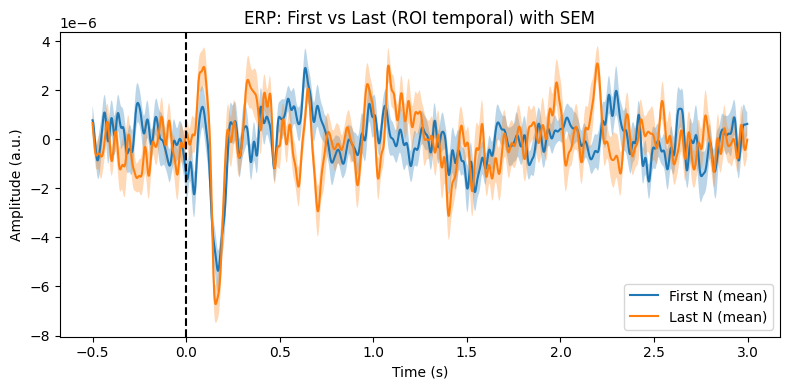

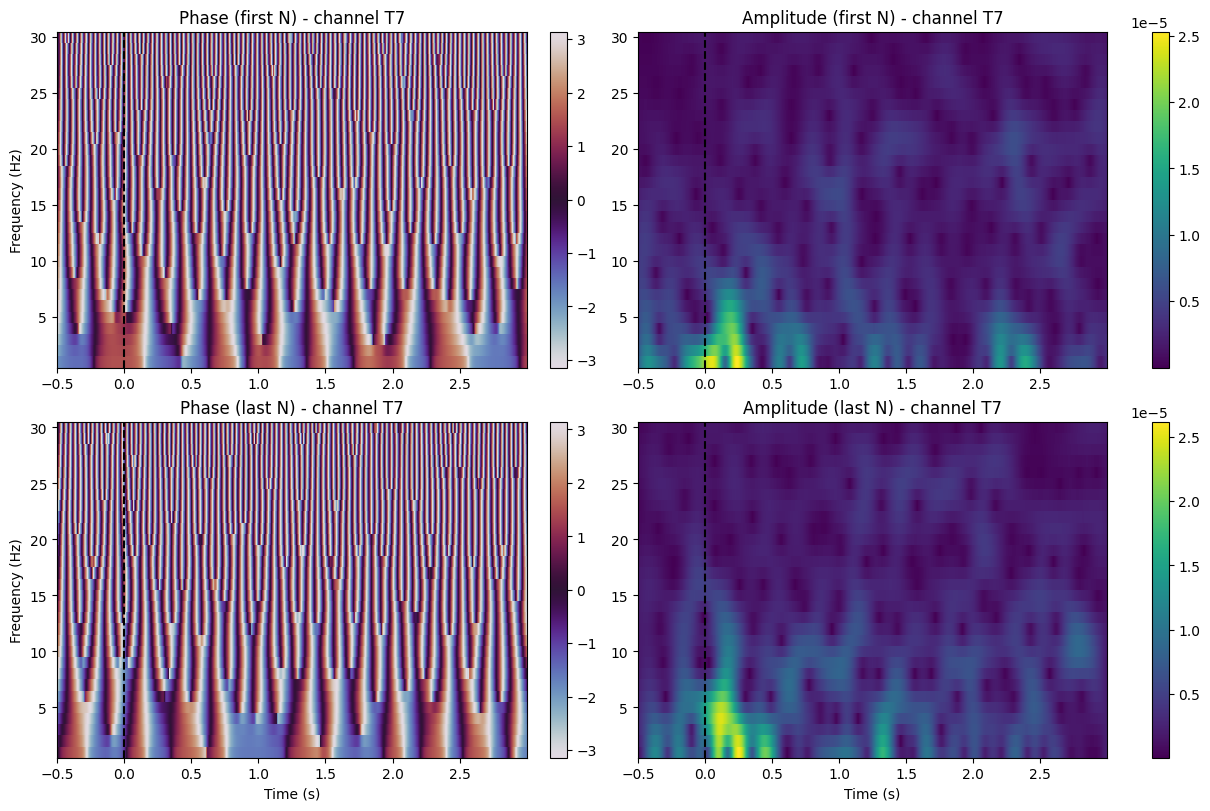

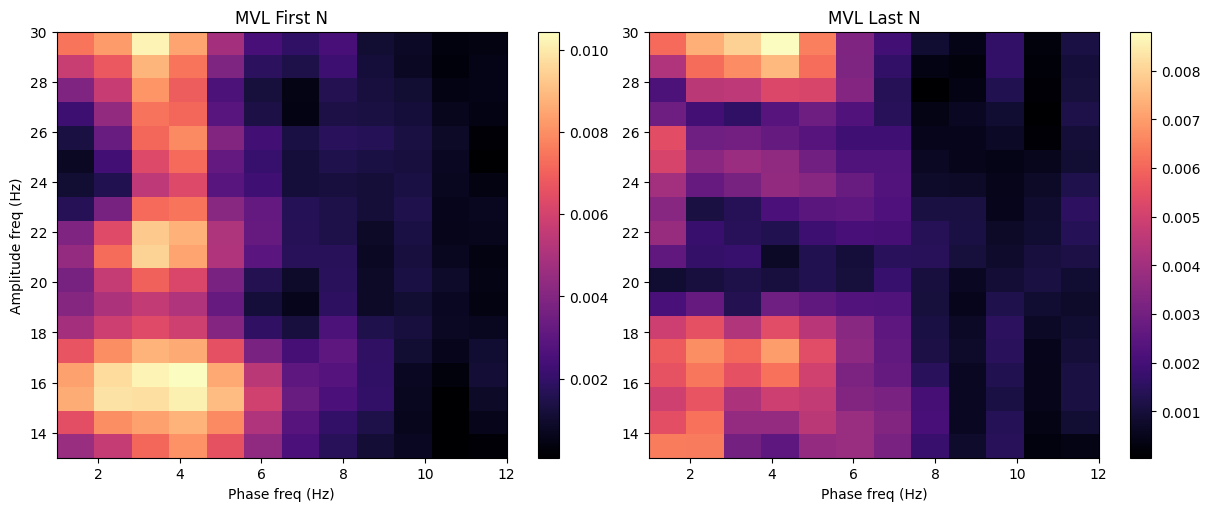

In [ ]:
# Additional plots: ERP (first/last 20 with SEM) and split TFR + MVL heatmaps
import numpy as np
import matplotlib.pyplot as plt

# determine N (first/last group size)
N = min(20, data.shape[0])
print(f'Using N={N} for first/last groups (available epochs: {data.shape[0]})')

# 1) ERP of first N vs last N with SEM (for ROI temporal channels)
if temporal_chs:
    # extract ROI epochs (n_epochs, n_times) already computed as temporal_epochs
    first_epochs = temporal_epochs[:N]  # (N, n_times)
    last_epochs = temporal_epochs[-N:]  # (N, n_times)
    # compute mean and SEM
    mean_first = first_epochs.mean(axis=0)
    sem_first = first_epochs.std(axis=0, ddof=1) / np.sqrt(first_epochs.shape[0])
    mean_last = last_epochs.mean(axis=0)
    sem_last = last_epochs.std(axis=0, ddof=1) / np.sqrt(last_epochs.shape[0])

    plt.figure(figsize=(8,4))
    plt.plot(aud.times, mean_first, label='First N (mean)')
    plt.fill_between(aud.times, mean_first - sem_first, mean_first + sem_first, alpha=0.3)
    plt.plot(aud.times, mean_last, label='Last N (mean)')
    plt.fill_between(aud.times, mean_last - sem_last, mean_last + sem_last, alpha=0.3)
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (a.u.)')
    plt.title('ERP: First vs Last (ROI temporal) with SEM')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Temporal ROI channels not available; skipping ERP first/last plot')

# 2) Split TFR (phase & amplitude) into first/last N and plot 4 panels
# Ensure tfr_complex exists
if 'tfr_complex' not in globals():
    raise RuntimeError('tfr_complex not found; run the Morlet TFR cell first')

tfr_first = tfr_complex[:N]  # (N, n_ch, n_freqs, n_times)
tfr_last = tfr_complex[-N:]  # (N, n_ch, n_freqs, n_times)

# average across epochs -> (n_ch, n_freqs, n_times)
tfr_first_mean = tfr_first.mean(axis=0)
tfr_last_mean = tfr_last.mean(axis=0)

phase_first = np.angle(tfr_first_mean)  # (n_ch, n_freqs, n_times)
phase_last = np.angle(tfr_last_mean)
amp_first = np.abs(tfr_first_mean)
amp_last = np.abs(tfr_last_mean)

# Pick representative channel index ch0 (temporal if available)
ch0 = aud.ch_names.index(temporal_chs[0]) if temporal_chs else 0

fig, axes = plt.subplots(2,2, figsize=(12,8), constrained_layout=True)
# Phase first
im0 = axes[0,0].pcolormesh(aud.times, freqs, phase_first[ch0], shading='auto', cmap='twilight')
axes[0,0].axvline(0, color='k', linestyle='--')
axes[0,0].set_title('Phase (first N) - channel '+aud.ch_names[ch0])
axes[0,0].set_ylabel('Frequency (Hz)')
fig.colorbar(im0, ax=axes[0,0])
# Amplitude first
im1 = axes[0,1].pcolormesh(aud.times, freqs, amp_first[ch0], shading='auto', cmap='viridis')
axes[0,1].axvline(0, color='k', linestyle='--')
axes[0,1].set_title('Amplitude (first N) - channel '+aud.ch_names[ch0])
fig.colorbar(im1, ax=axes[0,1])
# Phase last
im2 = axes[1,0].pcolormesh(aud.times, freqs, phase_last[ch0], shading='auto', cmap='twilight')
axes[1,0].axvline(0, color='k', linestyle='--')
axes[1,0].set_title('Phase (last N) - channel '+aud.ch_names[ch0])
axes[1,0].set_ylabel('Frequency (Hz)')
axes[1,0].set_xlabel('Time (s)')
fig.colorbar(im2, ax=axes[1,0])
# Amplitude last
im3 = axes[1,1].pcolormesh(aud.times, freqs, amp_last[ch0], shading='auto', cmap='viridis')
axes[1,1].axvline(0, color='k', linestyle='--')
axes[1,1].set_title('Amplitude (last N) - channel '+aud.ch_names[ch0])
axes[1,1].set_xlabel('Time (s)')
fig.colorbar(im3, ax=axes[1,1])
plt.show()

# 3) Compute MVL matrix (low 1-12 Hz as phase x high 13-30 Hz as amplitude) for first vs last groups
low_mask = (freqs >= 1) & (freqs <= 12)
high_mask = (freqs >= 13) & (freqs <= 30)
low_freqs = freqs[low_mask]
high_freqs = freqs[high_mask]
mvl_first = np.zeros((len(low_freqs), len(high_freqs)))
mvl_last = np.zeros_like(mvl_first)

# function to compute MVL scalar for given low_idx and high_idx on a group tfr (n_epochs, n_ch, n_freqs, n_times)
def compute_mvl_matrix(tfr_group, low_inds, high_inds):
    # tfr_group: (n_epochs, n_ch, n_freqs, n_times)
    out = np.zeros((len(low_inds), len(high_inds)))
    for i_li, li in enumerate(low_inds):
        for j_hi, hi in enumerate(high_inds):
            complex_low = tfr_group[:, :, li, :]  # (n_epochs, n_ch, n_times)
            phase_low = np.angle(complex_low)
            amp_high = np.abs(tfr_group[:, :, hi, :])
            vector = amp_high * np.exp(1j * phase_low)
            # mean over epochs and time and channels -> scalar; normalize by mean amp
            vec_mean = vector.mean(axis=(0,2)).mean()  # mean over epochs/time -> (n_ch) then mean over ch -> scalar
            amp_mean = amp_high.mean(axis=(0,2)).mean()
            out[i_li, j_hi] = np.abs(vec_mean) / (amp_mean + 1e-12)
    return out

mvl_first = compute_mvl_matrix(tfr_first, np.where(low_mask)[0], np.where(high_mask)[0])
mvl_last = compute_mvl_matrix(tfr_last, np.where(low_mask)[0], np.where(high_mask)[0])

# Plot MVL heatmaps (low freq on x, high freq on y)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
im1 = ax1.imshow(mvl_first.T, aspect='auto', origin='lower', extent=[low_freqs[0], low_freqs[-1], high_freqs[0], high_freqs[-1]], cmap='magma')
ax1.set_xlabel('Phase freq (Hz)')
ax1.set_ylabel('Amplitude freq (Hz)')
ax1.set_title('MVL First N')
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(mvl_last.T, aspect='auto', origin='lower', extent=[low_freqs[0], low_freqs[-1], high_freqs[0], high_freqs[-1]], cmap='magma')
ax2.set_xlabel('Phase freq (Hz)')
ax2.set_title('MVL Last N')
fig.colorbar(im2, ax=ax2)
plt.show()

Plotting tactile ROI ERP (first vs last) with SEM...


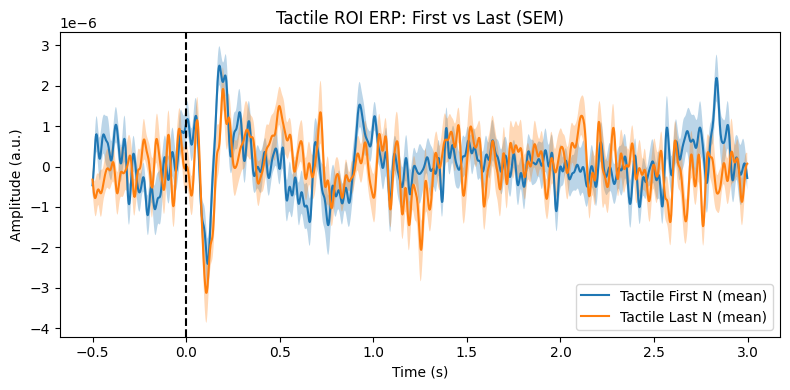

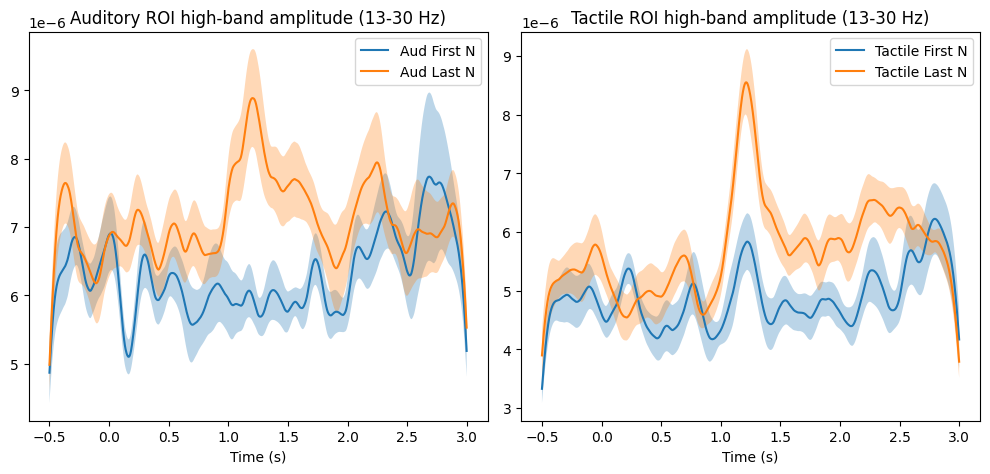

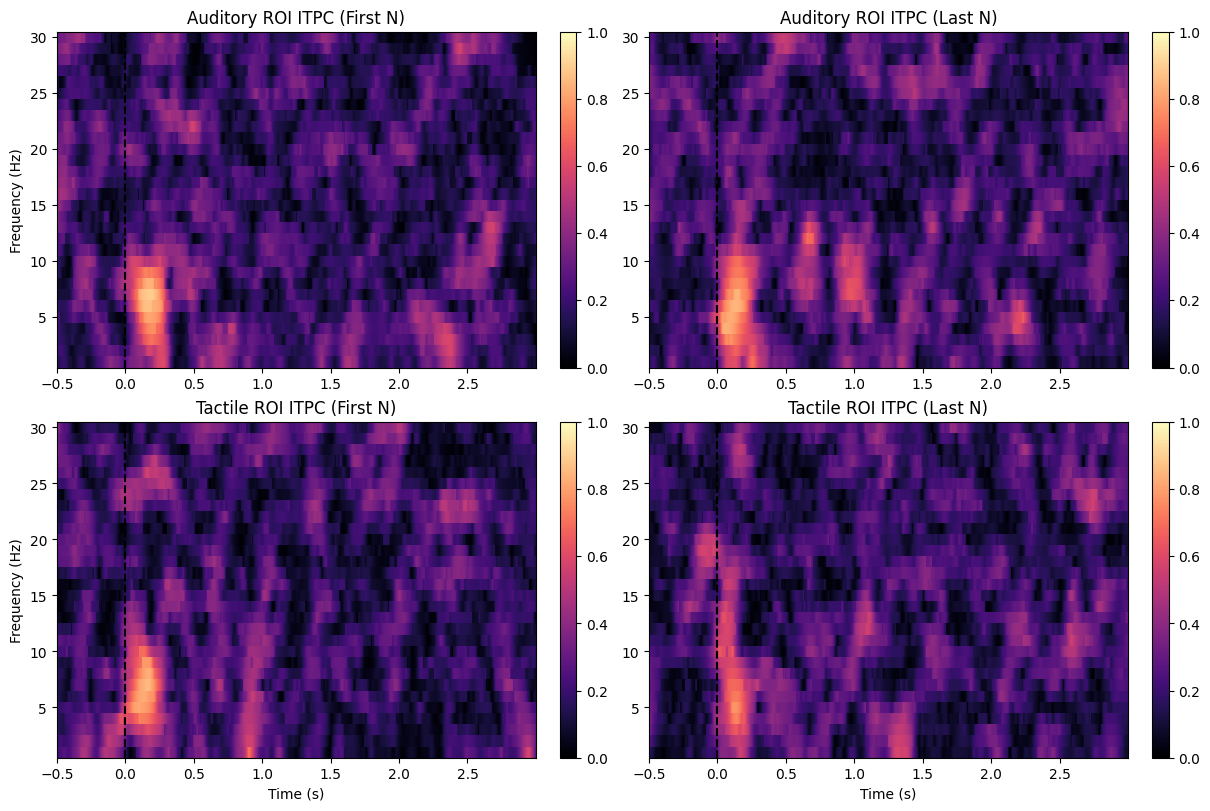

Computing MVL for auditory ROI...
Computing MVL for tactile ROI...
Computing MVL for tactile ROI...


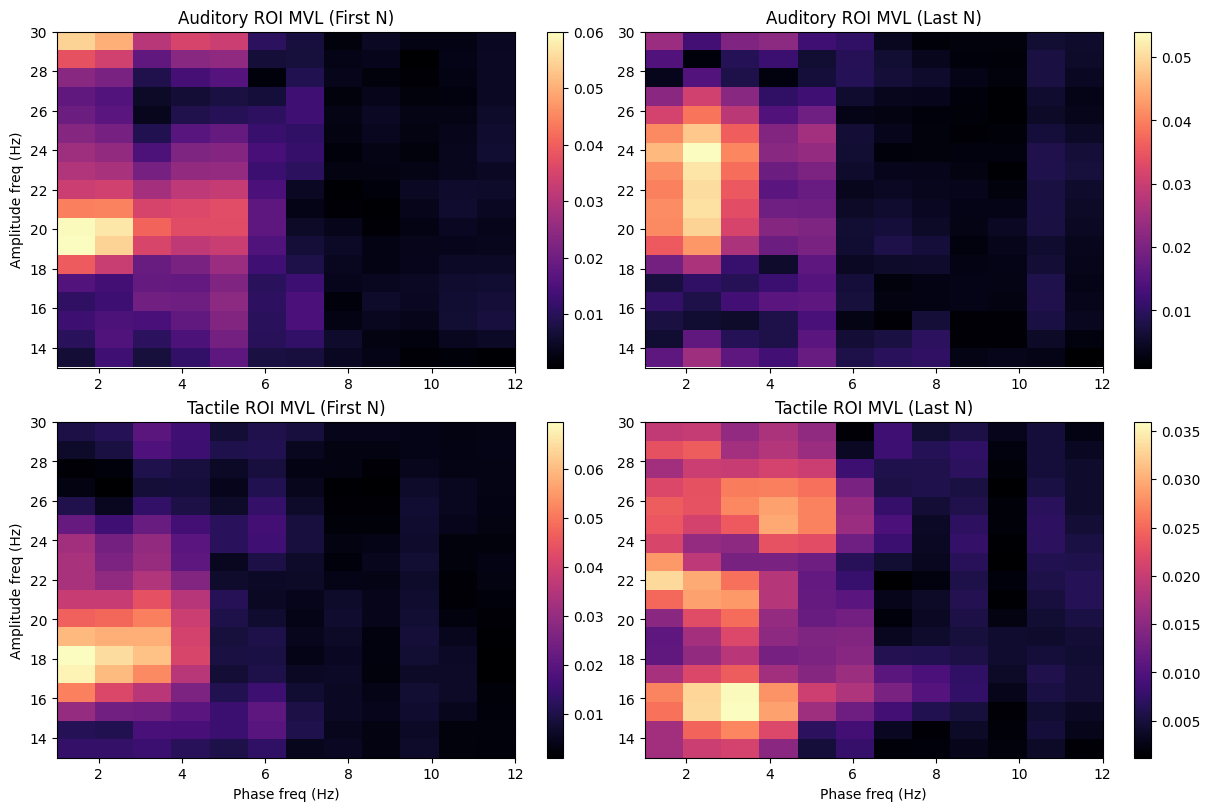

In [ ]:
# ROI-based amplitude / ITPC / ERP (tactile) plots and MVL for both auditory (temporal) and tactile ROIs
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Sanity checks for required variables
for var in ('tfr_complex','freqs','aud'):
    if var not in globals():
        raise RuntimeError(f'{var} not found; run the earlier cells that compute the Morlet TFR and define "aud"')

# Determine ROI channel indices (temporal = auditory ROI, tactile = tactile ROI)
aud_chs = [ch for ch in temporal_chs]  # T7/T8 if present
tac_chs = [ch for ch in tactile_chs]  # C3/C4 if present
aud_idx = [aud.ch_names.index(ch) for ch in aud_chs] if len(aud_chs) else []
tac_idx = [aud.ch_names.index(ch) for ch in tac_chs] if len(tac_chs) else []

# Number to split first/last groups (use same N as above if present)
N = min(20, data.shape[0])

# Helper: compute ITPC (inter-trial phase coherence) for an array of phases (n_epochs, n_freqs, n_times)
def compute_itpc(phase_epochs):
    # returns (n_freqs, n_times)
    return np.abs(np.mean(np.exp(1j * phase_epochs), axis=0))

# Helper: compute MVL matrix for ROI-averaged tfr (n_epochs, n_freqs, n_times)
def compute_mvl_matrix_roi(tfr_roi, low_inds, high_inds):
    # tfr_roi: (n_epochs, n_freqs, n_times)
    out = np.zeros((len(low_inds), len(high_inds)))
    for i_li, li in enumerate(low_inds):
        for j_hi, hi in enumerate(high_inds):
            phase_low = np.angle(tfr_roi[:, li, :])        # (n_epochs, n_times)
            amp_high = np.abs(tfr_roi[:, hi, :])          # (n_epochs, n_times)
            vector = amp_high * np.exp(1j * phase_low)    # (n_epochs, n_times)
            vec_mean = vector.mean()                      # scalar (mean over epochs & time)
            amp_mean = amp_high.mean()                    # scalar
            out[i_li, j_hi] = np.abs(vec_mean) / (amp_mean + 1e-12)
    return out

# Masks for low/high bands used previously
low_mask = (freqs >= 1) & (freqs <= 12)
high_mask = (freqs >= 13) & (freqs <= 30)
low_inds = np.where(low_mask)[0]
high_inds = np.where(high_mask)[0]
low_freqs = freqs[low_mask]
high_freqs = freqs[high_mask]

# ROI-averaged TFRs: average channel dimension for each ROI (if channels present)
tfr = tfr_complex  # alias

if aud_idx:
    tfr_aud = tfr[:, aud_idx, :, :].mean(axis=1)   # (n_epochs, n_freqs, n_times)
else:
    tfr_aud = None
if tac_idx:
    tfr_tac = tfr[:, tac_idx, :, :].mean(axis=1)
else:
    tfr_tac = None

# 1) ERP for tactile ROI with SEM, split by first/last N
if tactile_chs:
    print('Plotting tactile ROI ERP (first vs last) with SEM...')
    tac_epochs = tactile_epochs  # (n_epochs, n_times)
    first_tac = tac_epochs[:N]
    last_tac = tac_epochs[-N:]
    mean_first = first_tac.mean(axis=0)
    sem_first = first_tac.std(axis=0, ddof=1) / np.sqrt(first_tac.shape[0])
    mean_last = last_tac.mean(axis=0)
    sem_last = last_tac.std(axis=0, ddof=1) / np.sqrt(last_tac.shape[0])
    plt.figure(figsize=(8,4))
    plt.plot(aud.times, mean_first, label='Tactile First N (mean)')
    plt.fill_between(aud.times, mean_first - sem_first, mean_first + sem_first, alpha=0.3)
    plt.plot(aud.times, mean_last, label='Tactile Last N (mean)')
    plt.fill_between(aud.times, mean_last - sem_last, mean_last + sem_last, alpha=0.3)
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (a.u.)')
    plt.title('Tactile ROI ERP: First vs Last (SEM)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Tactile channels not available; skipping tactile ERP')

# 2) Amplitude time-series (high band) for auditory and tactile ROIs, split first/last
plt.figure(figsize=(10,5))
if tfr_aud is not None:
    amp_aud = np.abs(tfr_aud)[:, high_mask, :].mean(axis=1)  # (n_epochs, n_times)
    first_amp = amp_aud[:N]
    last_amp = amp_aud[-N:]
    m_first = first_amp.mean(axis=0)
    s_first = first_amp.std(axis=0, ddof=1) / np.sqrt(first_amp.shape[0])
    m_last = last_amp.mean(axis=0)
    s_last = last_amp.std(axis=0, ddof=1) / np.sqrt(last_amp.shape[0])
    plt.subplot(1,2,1)
    plt.plot(aud.times, m_first, label='Aud First N')
    plt.fill_between(aud.times, m_first - s_first, m_first + s_first, alpha=0.3)
    plt.plot(aud.times, m_last, label='Aud Last N')
    plt.fill_between(aud.times, m_last - s_last, m_last + s_last, alpha=0.3)
    plt.title('Auditory ROI high-band amplitude (13-30 Hz)')
    plt.xlabel('Time (s)')
    plt.legend()
else:
    plt.subplot(1,2,1)
    plt.text(0.5,0.5,'No auditory ROI channels', ha='center')

if tfr_tac is not None:
    amp_tac = np.abs(tfr_tac)[:, high_mask, :].mean(axis=1)
    first_amp = amp_tac[:N]
    last_amp = amp_tac[-N:]
    m_first = first_amp.mean(axis=0)
    s_first = first_amp.std(axis=0, ddof=1) / np.sqrt(first_amp.shape[0])
    m_last = last_amp.mean(axis=0)
    s_last = last_amp.std(axis=0, ddof=1) / np.sqrt(last_amp.shape[0])
    plt.subplot(1,2,2)
    plt.plot(aud.times, m_first, label='Tactile First N')
    plt.fill_between(aud.times, m_first - s_first, m_first + s_first, alpha=0.3)
    plt.plot(aud.times, m_last, label='Tactile Last N')
    plt.fill_between(aud.times, m_last - s_last, m_last + s_last, alpha=0.3)
    plt.title('Tactile ROI high-band amplitude (13-30 Hz)')
    plt.xlabel('Time (s)')
    plt.legend()
else:
    plt.subplot(1,2,2)
    plt.text(0.5,0.5,'No tactile ROI channels', ha='center')

plt.tight_layout()
plt.show()

# 3) Compute and plot ITPC (phase coherence) for first/last groups for both ROIs
fig, axes = plt.subplots(2,2, figsize=(12,8), constrained_layout=True)
# Auditory ROI ITPC
if tfr_aud is not None:
    tfr_first_aud = tfr_aud[:N]
    tfr_last_aud = tfr_aud[-N:]
    phase_first = np.angle(tfr_first_aud)
    phase_last = np.angle(tfr_last_aud)
    itpc_first = compute_itpc(phase_first)   # (n_freqs, n_times)
    itpc_last = compute_itpc(phase_last)
    im0 = axes[0,0].pcolormesh(aud.times, freqs, itpc_first, shading='auto', cmap='magma', vmin=0, vmax=1)
    axes[0,0].axvline(0, color='k', linestyle='--')
    axes[0,0].set_title('Auditory ROI ITPC (First N)')
    axes[0,0].set_ylabel('Frequency (Hz)')
    fig.colorbar(im0, ax=axes[0,0])
    im1 = axes[0,1].pcolormesh(aud.times, freqs, itpc_last, shading='auto', cmap='magma', vmin=0, vmax=1)
    axes[0,1].axvline(0, color='k', linestyle='--')
    axes[0,1].set_title('Auditory ROI ITPC (Last N)')
    fig.colorbar(im1, ax=axes[0,1])
else:
    axes[0,0].text(0.5,0.5,'No auditory ROI', ha='center')
    axes[0,1].text(0.5,0.5,'No auditory ROI', ha='center')

# Tactile ROI ITPC
if tfr_tac is not None:
    tfr_first_tac = tfr_tac[:N]
    tfr_last_tac = tfr_tac[-N:]
    phase_first = np.angle(tfr_first_tac)
    phase_last = np.angle(tfr_last_tac)
    itpc_first = compute_itpc(phase_first)
    itpc_last = compute_itpc(phase_last)
    im2 = axes[1,0].pcolormesh(aud.times, freqs, itpc_first, shading='auto', cmap='magma', vmin=0, vmax=1)
    axes[1,0].axvline(0, color='k', linestyle='--')
    axes[1,0].set_title('Tactile ROI ITPC (First N)')
    axes[1,0].set_xlabel('Time (s)')
    axes[1,0].set_ylabel('Frequency (Hz)')
    fig.colorbar(im2, ax=axes[1,0])
    im3 = axes[1,1].pcolormesh(aud.times, freqs, itpc_last, shading='auto', cmap='magma', vmin=0, vmax=1)
    axes[1,1].axvline(0, color='k', linestyle='--')
    axes[1,1].set_title('Tactile ROI ITPC (Last N)')
    axes[1,1].set_xlabel('Time (s)')
    fig.colorbar(im3, ax=axes[1,1])
else:
    axes[1,0].text(0.5,0.5,'No tactile ROI', ha='center')
    axes[1,1].text(0.5,0.5,'No tactile ROI', ha='center')

plt.show()

# 4) MVL matrices for auditory and tactile ROIs (plot first & last side-by-side)
# Reuse low_inds/high_inds defined earlier
if tfr_aud is not None:
    print('Computing MVL for auditory ROI...')
    mvl_aud_first = compute_mvl_matrix_roi(tfr_aud[:N], low_inds, high_inds)
    mvl_aud_last = compute_mvl_matrix_roi(tfr_aud[-N:], low_inds, high_inds)
else:
    mvl_aud_first = mvl_aud_last = None
if tfr_tac is not None:
    print('Computing MVL for tactile ROI...')
    mvl_tac_first = compute_mvl_matrix_roi(tfr_tac[:N], low_inds, high_inds)
    mvl_tac_last = compute_mvl_matrix_roi(tfr_tac[-N:], low_inds, high_inds)
else:
    mvl_tac_first = mvl_tac_last = None

# Plot MVL heatmaps: auditory (top row) tactile (bottom row) first vs last columns
fig, axes = plt.subplots(2,2, figsize=(12,8), constrained_layout=True)
if mvl_aud_first is not None:
    im = axes[0,0].imshow(mvl_aud_first.T, aspect='auto', origin='lower', extent=[low_freqs[0], low_freqs[-1], high_freqs[0], high_freqs[-1]], cmap='magma')
    axes[0,0].set_title('Auditory ROI MVL (First N)')
    axes[0,0].set_ylabel('Amplitude freq (Hz)')
    fig.colorbar(im, ax=axes[0,0])
    im = axes[0,1].imshow(mvl_aud_last.T, aspect='auto', origin='lower', extent=[low_freqs[0], low_freqs[-1], high_freqs[0], high_freqs[-1]], cmap='magma')
    axes[0,1].set_title('Auditory ROI MVL (Last N)')
    fig.colorbar(im, ax=axes[0,1])
else:
    axes[0,0].text(0.5,0.5,'No auditory MVL', ha='center')
    axes[0,1].text(0.5,0.5,'No auditory MVL', ha='center')

if mvl_tac_first is not None:
    im = axes[1,0].imshow(mvl_tac_first.T, aspect='auto', origin='lower', extent=[low_freqs[0], low_freqs[-1], high_freqs[0], high_freqs[-1]], cmap='magma')
    axes[1,0].set_title('Tactile ROI MVL (First N)')
    axes[1,0].set_xlabel('Phase freq (Hz)')
    axes[1,0].set_ylabel('Amplitude freq (Hz)')
    fig.colorbar(im, ax=axes[1,0])
    im = axes[1,1].imshow(mvl_tac_last.T, aspect='auto', origin='lower', extent=[low_freqs[0], low_freqs[-1], high_freqs[0], high_freqs[-1]], cmap='magma')
    axes[1,1].set_title('Tactile ROI MVL (Last N)')
    axes[1,1].set_xlabel('Phase freq (Hz)')
    fig.colorbar(im, ax=axes[1,1])
else:
    axes[1,0].text(0.5,0.5,'No tactile MVL', ha='center')
    axes[1,1].text(0.5,0.5,'No tactile MVL', ha='center')

plt.show()

Extracting parameters from /Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/notebooks/../data/processed/BLA/binepochs filtered ICArej BLAAvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
0 projection items activated
Ready.
Ready.
Extracting parameters from /Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/notebooks/../data/processed/BLT/binepochs filtered ICArej BLTAvgBOS2.set...
Extracting parameters from /Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/notebooks/../data/processed/BLT/binepochs filtered ICArej BLTAvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
0 projection items activated
Ready.


/Users/yinqihuang/.neural_mi_tmp/ipykernel_69744/641858828.py:137: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  BLA = mne.io.read_epochs_eeglab(BLA_file_path)
/Users/yinqihuang/.neural_mi_tmp/ipykernel_69744/641858828.py:141: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  BLT = mne.io.read_epochs_eeglab(BLT_file_path)



=== Analyzing BLA ===
data.shape -> (n_epochs, n_channels, n_times): (120, 32, 1792)
n_epochs: 120 n_channels: 32 n_times: 1792
channel names (sample): ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4']
sfreq (Hz): 512.0
time range (s): -0.5 to 2.998046875
Applying 1–30 Hz band-pass...
Filter done.
Applying baseline correction (-0.5 to 0 s)...
Applying baseline correction (mode: mean)
Baseline done.
Temporal channels: ['T7', 'T8'] Tactile channels: ['C3', 'C4']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filter done.
Applying baseline correction (-0.5 to 0 s)...
Applying baseline correction (mode: mean)
Baseline done.
Temporal channels: ['T7', 'T8'] Tactile channels: ['C3', 'C4']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should

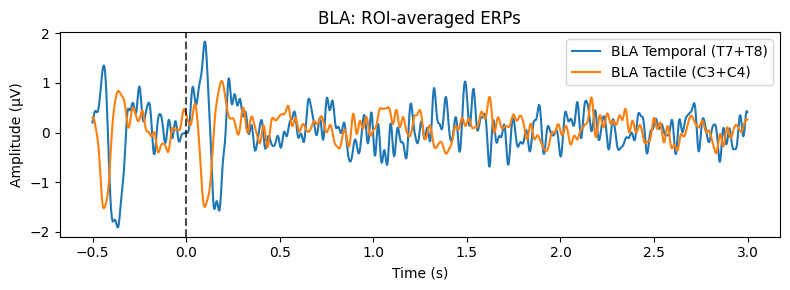

Topomap times: [-0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
BLA: plotting topomaps for FIRST 20 trials...


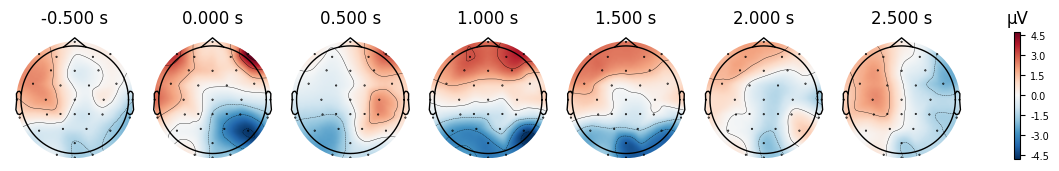

BLA: plotting topomaps for LAST 20 trials...


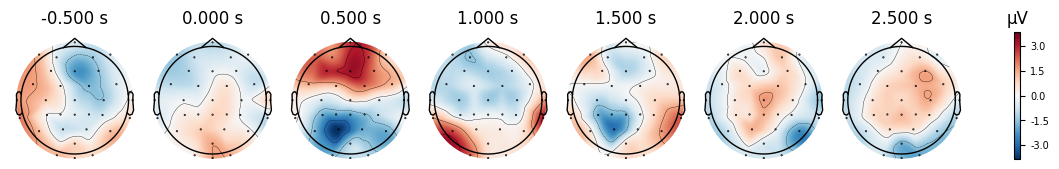

BLA: computing Morlet TFR (complex)...
tfr_complex.shape = (120, 32, 30, 1792)
tfr_complex.shape = (120, 32, 30, 1792)

=== Analyzing BLT ===
data.shape -> (n_epochs, n_channels, n_times): (120, 32, 1792)
n_epochs: 120 n_channels: 32 n_times: 1792
channel names (sample): ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4']
sfreq (Hz): 512.0
time range (s): -0.5 to 2.998046875
Applying 1–30 Hz band-pass...

=== Analyzing BLT ===
data.shape -> (n_epochs, n_channels, n_times): (120, 32, 1792)
n_epochs: 120 n_channels: 32 n_times: 1792
channel names (sample): ['AF7', 'FPZ', 'AF8', 'AF3', 'AF4', 'F3', 'FZ', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4']
sfreq (Hz): 512.0
time range (s): -0.5 to 2.998046875
Applying 1–30 Hz band-pass...
Filter done.
Applying baseline correction (-0.5 to 0 s)...
Applying baseline correction (mode: mean)
Baseline done.
Temporal channels: ['T7', 'T8'] Tactile channels: ['C3', 'C4']
NOTE: pick_chann

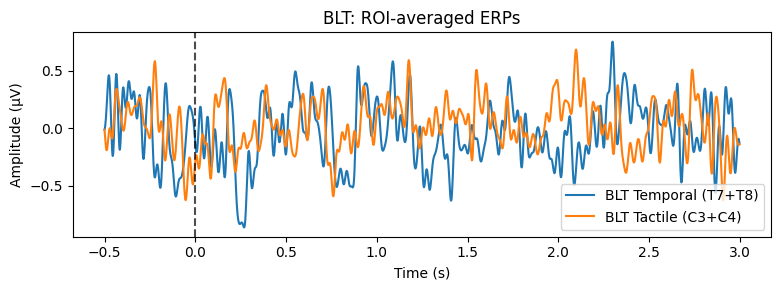

Topomap times: [-0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
BLT: plotting topomaps for FIRST 20 trials...


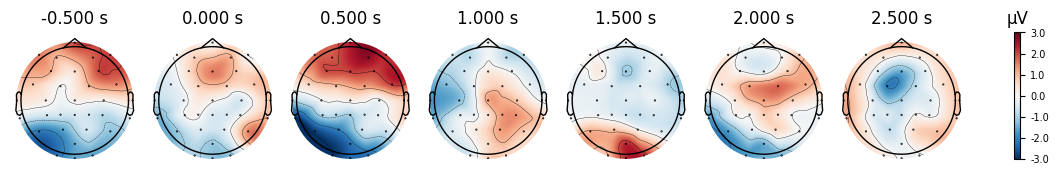

BLT: plotting topomaps for LAST 20 trials...


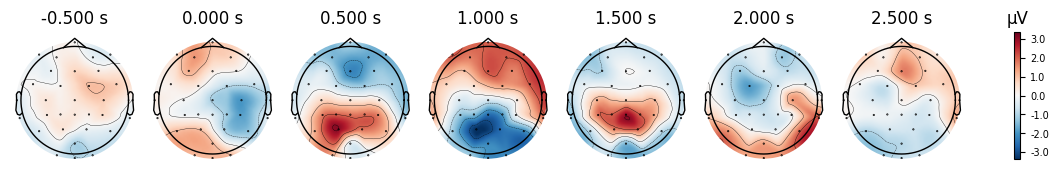

BLT: computing Morlet TFR (complex)...
tfr_complex.shape = (120, 32, 30, 1792)
tfr_complex.shape = (120, 32, 30, 1792)


In [ ]:
from pathlib import Path
import numpy as np
import mne
from mne.time_frequency import tfr_array_morlet
import matplotlib.pyplot as plt

# ------------------------
# Helper analysis function
# ------------------------

def analyze_epochs(epochs, dataset_name="Dataset"):
    """
    Run the same analysis pipeline (filtering, baseline, ROI ERPs, topomaps, TFR)
    on a given mne.Epochs object.
    """

    print(f"\n=== Analyzing {dataset_name} ===")

    # Work on a copy
    ep = epochs.copy()
    ep.load_data()

    # Basic info
    data = ep.get_data()  # (n_epochs, n_channels, n_times)
    n_epochs, n_channels, n_times = data.shape
    print('data.shape -> (n_epochs, n_channels, n_times):', data.shape)
    print('n_epochs:', n_epochs, 'n_channels:', n_channels, 'n_times:', n_times)
    print('channel names (sample):', ep.ch_names[:min(16, len(ep.ch_names))])

    sfreq = ep.info['sfreq']
    print('sfreq (Hz):', sfreq)
    print('time range (s):', ep.times[0], 'to', ep.times[-1])

    # -------- Filter 1–30 Hz --------
    print('Applying 1–30 Hz band-pass...')
    ep.filter(l_freq=1.0, h_freq=30.0, picks='eeg',
              fir_design='firwin', verbose=False)
    print('Filter done.')

    # -------- Baseline correction --------
    # baseline interval: -0.5 to 0 s (pre-stimulus)
    print('Applying baseline correction (-0.5 to 0 s)...')
    ep.apply_baseline((-0.5, 0.0))
    print('Baseline done.')

    # ROI channels (temporal = T7+T8; tactile = C3+C4)
    temporal_chs = [ch for ch in ('T7', 'T8') if ch in ep.ch_names]
    tactile_chs  = [ch for ch in ('C3', 'C4') if ch in ep.ch_names]
    print('Temporal channels:', temporal_chs, 'Tactile channels:', tactile_chs)

    def roi_mean_epochs(epochs_obj, channels):
        if len(channels) == 0:
            return None
        arr = epochs_obj.copy().pick_channels(channels).get_data()  # (n_epochs, n_ch, n_times)
        return arr.mean(axis=1)  # (n_epochs, n_times)

    temporal_epochs = roi_mean_epochs(ep, temporal_chs)
    tactile_epochs  = roi_mean_epochs(ep, tactile_chs)

    print('temporal_epochs shape:', None if temporal_epochs is None else temporal_epochs.shape)
    print('tactile_epochs shape:', None if tactile_epochs is None else tactile_epochs.shape)

    # -------- Quick ERP plots (average across epochs) --------
    # Data in ep are still in Volts; convert to microvolts for plotting
    scale_factor = 1e6  # V -> µV

    plt.figure(figsize=(8, 3))
    if temporal_epochs is not None:
        plt.plot(ep.times, temporal_epochs.mean(axis=0) * scale_factor,
                 label=f'{dataset_name} Temporal (T7+T8)')
    if tactile_epochs is not None:
        plt.plot(ep.times, tactile_epochs.mean(axis=0) * scale_factor,
                 label=f'{dataset_name} Tactile (C3+C4)')
    plt.axvline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')   # microvolt unit
    plt.legend()
    plt.title(f'{dataset_name}: ROI-averaged ERPs')
    plt.tight_layout()
    plt.show()

    # -------- Topomaps: first N vs last N trials --------
    N = min(5, len(ep))
    if N >= 1:
        ev_first = ep[:N].average()
        ev_last  = ep[-N:].average()

        times_plot = np.arange(-0.5, 3.01, 0.5)
        times_plot = [t for t in times_plot
                      if t >= ev_first.times[0] and t <= ev_first.times[-1]]
        print('Topomap times:', times_plot)

        print(f"{dataset_name}: plotting topomaps for FIRST {N} trials...")
        ev_first.plot_topomap(times=times_plot, ch_type='eeg',
                              time_unit='s', show=True)
        print(f"{dataset_name}: plotting topomaps for LAST {N} trials...")
        ev_last.plot_topomap(times=times_plot, ch_type='eeg',
                             time_unit='s', show=True)
    else:
        print(f"{dataset_name}: not enough trials for topomap (N={len(ep)}).")

    # -------- TFR (Morlet) in Volts (no scaling) --------
    print(f'{dataset_name}: computing Morlet TFR (complex)...')
    freqs = np.arange(1, 31)  # 1..30 Hz
    n_cycles = freqs / 2.0

    data = ep.get_data()  # (n_epochs, n_channels, n_times)
    tfr_complex = tfr_array_morlet(
        data, sfreq=sfreq, freqs=freqs, n_cycles=n_cycles,
        output='complex', decim=1
    )
    print('tfr_complex.shape =', tfr_complex.shape)
    # shapes: (n_epochs, n_channels, n_freqs, n_times)
    phase = np.angle(tfr_complex)
    amp   = np.abs(tfr_complex)

    phase_avg = phase.mean(axis=0)  # (n_channels, n_freqs, n_times)
    amp_avg   = amp.mean(axis=0)

    # Return useful results for further analysis
    return {
        "epochs": ep,
        "temporal_epochs": temporal_epochs,
        "tactile_epochs": tactile_epochs,
        "phase_avg": phase_avg,
        "amp_avg": amp_avg,
        "freqs": freqs,
        "times": ep.times,
    }

# ------------------------
# Load BLA and BLT datasets
# ------------------------

BLA_data_path = Path("../data/processed/BLA/")
BLA_file_path = BLA_data_path / "binepochs filtered ICArej BLAAvgBOS2.set"
BLA = mne.io.read_epochs_eeglab(BLA_file_path)

BLT_data_path = Path("../data/processed/BLT/")
BLT_file_path = BLT_data_path / "binepochs filtered ICArej BLTAvgBOS2.set"
BLT = mne.io.read_epochs_eeglab(BLT_file_path)

results_BLA = analyze_epochs(BLA, dataset_name="BLA")
results_BLT = analyze_epochs(BLT, dataset_name="BLT")

In [6]:
print(BLA.events[:10])
print(BLT.events[:10])


[[  257     0     1]
 [ 2049     0     2]
 [ 3841     0     1]
 [ 5633     0     2]
 [ 7425     0     1]
 [ 9217     0     2]
 [11009     0     1]
 [12801     0     2]
 [14593     0     1]
 [16385     0     2]]
[[  257     0     1]
 [ 2049     0     2]
 [ 3841     0     1]
 [ 5633     0     2]
 [ 7425     0     1]
 [ 9217     0     2]
 [11009     0     1]
 [12801     0     2]
 [14593     0     1]
 [16385     0     2]]


In [4]:
import mne
import numpy as np
from pathlib import Path
import sys
from pathlib import Path

# Path to project root (one level above notebooks/)
project_root = Path("..").resolve()
src_path = project_root / "src"

# Add src folder to Python path
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Now import the function
from run_trialwise_mi import run_trialwise_mi

print("Imported run_trialwise_mi successfully!")

# ---------- Load the epochs ----------

BLA_data_path = Path("../data/processed/BLA/")
BLA_file_path = BLA_data_path / "binepochs filtered ICArej BLAAvgBOS2.set"
BLA = mne.io.read_epochs_eeglab(BLA_file_path)

BLT_data_path = Path("../data/processed/BLT/")  # change to BLA if they live in same folder
BLT_file_path = BLT_data_path / "binepochs filtered ICArej BLTAvgBOS2.set"
BLT = mne.io.read_epochs_eeglab(BLT_file_path)

print("BLA channels:", BLA.ch_names[:20])
print("BLT channels:", BLT.ch_names[:20])

# ---------- Optional: filter 1–30 Hz on copies ----------

BLA_filt = BLA.copy().load_data()
BLT_filt = BLT.copy().load_data()

BLA_filt.filter(l_freq=1.0, h_freq=30.0, picks='eeg',
                fir_design='firwin', verbose=False)
BLT_filt.filter(l_freq=1.0, h_freq=30.0, picks='eeg',
                fir_design='firwin', verbose=False)

# ---------- Helper to extract x=C3, y=T7 per trial ----------

def extract_xy_trials(epochs, ch_x="C3", ch_y="T7", zscore=True):
    """
    From an mne.Epochs object, extract channels (C3, T7) and optionally z-score
    each trial independently.

    Returns
    -------
    x_trials : (n_trials, n_times)
    y_trials : (n_trials, n_times)
    """

    # Make sure channels exist
    if ch_x not in epochs.ch_names:
        raise ValueError(f"Channel {ch_x} not found in epochs.ch_names")
    if ch_y not in epochs.ch_names:
        raise ValueError(f"Channel {ch_y} not found in epochs.ch_names")

    idx_x = epochs.ch_names.index(ch_x)
    idx_y = epochs.ch_names.index(ch_y)

    # Full data: (n_trials, n_channels, n_times)
    data = epochs.get_data()

    # Extract channels
    x_trials = data[:, idx_x, :]   # (n_trials, n_times)
    y_trials = data[:, idx_y, :]

    # -------- Z-score each trial --------
    if zscore:
        # per-trial z-score:  (t - mean_t) / std_t
        for t in range(x_trials.shape[0]):
            # X
            mu_x = x_trials[t].mean()
            sd_x = x_trials[t].std()
            if sd_x > 0:
                x_trials[t] = (x_trials[t] - mu_x) / sd_x

            # Y
            mu_y = y_trials[t].mean()
            sd_y = y_trials[t].std()
            if sd_y > 0:
                y_trials[t] = (y_trials[t] - mu_y) / sd_y

    print(f"{ch_x} x_trials shape:", x_trials.shape)
    print(f"{ch_y} y_trials shape:", y_trials.shape)

    return x_trials, y_trials


# Extract for BLA
# x_BLA, y_BLA = extract_xy_trials(BLA_filt, ch_x="C3", ch_y="T7")

# Extract for BLT
x_BLT, y_BLT = extract_xy_trials(BLT_filt, ch_x="C3", ch_y="T7")

# ---------- Call run_trialwise_mi for each dataset ----------

# summary_BLA, curves_BLA, curves_shuf_BLA = run_trialwise_mi(
#     x_trials=x_BLA,
#     y_trials=y_BLA,
#     label="BLA",
#     ch_pair=("C3", "T7"),
#     out_dir="../data/processed/mi_results",
#     resume=True,           # set False if you want a fresh run
# )

summary_BLT, curves_BLT, curves_shuf_BLT = run_trialwise_mi(
    x_trials=x_BLT,
    y_trials=y_BLT,
    label="BLT",
    ch_pair=("C3", "T7"),
    out_dir="../data/processed/mi_results",
    resume=True,
)


Imported run_trialwise_mi successfully!
Extracting parameters from /Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/notebooks/../data/processed/BLA/binepochs filtered ICArej BLAAvgBOS2.set...
Not setting metadata
120 matching events found
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/notebooks/../data/processed/BLT/binepochs filtered ICArej BLTAvgBOS2.set...
Not setting metadata
Extracting parameters from /Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/notebooks/../data/processed/BLT/binepochs filtered ICArej BLTAvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Ready.
BLA channels: ['AF7', 'FPZ', '

/Users/yinqihuang/.neural_mi_tmp/ipykernel_69744/515489582.py:24: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  BLA = mne.io.read_epochs_eeglab(BLA_file_path)
/Users/yinqihuang/.neural_mi_tmp/ipykernel_69744/515489582.py:28: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  BLT = mne.io.read_epochs_eeglab(BLT_file_path)


C3 x_trials shape: (120, 1792)
T7 y_trials shape: (120, 1792)


Trials (BLT):   0%|          | 0/120 [00:00<?, ?it/s]

2025-11-13 07:46:13 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-13 07:46:13 - neural_mi - INFO - Preparing 30 tasks for lag analysis.
2025-11-13 07:46:13 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...
2025-11-13 07:46:13 - neural_mi - INFO - Preparing 30 tasks for lag analysis.
2025-11-13 07:46:13 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Run lag-600_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-560_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-520_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-480_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-440_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-400_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-360_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-320_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-280_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-240_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-200_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-160_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-120_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-80_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-40_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag40_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag80_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag120_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag160_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag200_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag240_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag280_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag320_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag360_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag400_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag440_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag480_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag520_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag560_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

2025-11-13 07:55:07 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-13 07:55:07 - neural_mi - INFO - Preparing 30 tasks for lag analysis.
2025-11-13 07:55:07 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...
2025-11-13 07:55:07 - neural_mi - INFO - Preparing 30 tasks for lag analysis.
2025-11-13 07:55:07 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Run lag-600_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-560_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-520_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-480_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-440_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-400_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-360_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-320_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-280_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-240_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-200_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-160_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-120_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-80_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-40_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag40_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag80_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag120_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag160_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag200_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag240_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag280_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag320_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag360_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag400_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag440_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag480_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag520_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag560_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

/Users/yinqihuang/Documents/Github/Phys-Cog-CISI-Group/src/run_trialwise_mi.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, new_row], ignore_index=True)
Trials (BLT):   1%|          | 1/120 [10:10<20:10:22, 610.28s/it]

2025-11-13 07:56:24 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-13 07:56:24 - neural_mi - INFO - Preparing 30 tasks for lag analysis.
2025-11-13 07:56:24 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...
2025-11-13 07:56:24 - neural_mi - INFO - Preparing 30 tasks for lag analysis.
2025-11-13 07:56:24 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Run lag-600_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Run lag-560_combo0:   0%|          | 0/300 [00:00<?, ?it/s]

Trials (BLT):   1%|          | 1/120 [46:19<91:52:10, 2779.24s/it]



KeyboardInterrupt: 